# Labelstudio exporter/importer

EstNLTK has classes for converting text annotations into [Labelstudio](https://labelstud.io/) format and back.

## PhraseTaggingTask

In a phrase tagging task, annotator can correct precomputed phrase borders, add new phrases and/or change phrase categories (e.g. a name category in a named entity annotation task).

#### Export to Labelstudio

In the following, we'll show how to prepare data and phrase tagging task for labelstudio manual annotation project. 

Let's take a simplified example where the goal is to annotate words belonging to two part of speeches: 'nimisõna' (nouns) and 'verb' (verbs). 
A partially annotated sentence will be displayed to the annotator, and the annotator has to correct part of speech tags, along with adding new annotations. 

In [1]:
from estnltk.converters.label_studio.labelling_configurations import PhraseTaggingConfiguration
from estnltk.converters.label_studio.labelling_tasks import PhraseTaggingTask

In [2]:
# Define example sentences
from estnltk import Text
sentences = [Text('Mees peeti kinni.'), Text('Tõin turult peeti ja paprikat.')]

In [3]:
# Automatically mark some (but not all) nouns and verbs in sentences
from estnltk.taggers.system.rule_taggers.extraction_rules.ruleset import Ruleset
from estnltk.taggers.system.rule_taggers.extraction_rules.static_extraction_rule import StaticExtractionRule
from estnltk.taggers.system.rule_taggers.taggers.substring_tagger import SubstringTagger
rules = Ruleset([
    StaticExtractionRule('peeti', {'label': 'verb'}),
    StaticExtractionRule('mees', {'label': 'nimisõna'}),
    StaticExtractionRule('turult', {'label': 'nimisõna'}),
])
tagger = SubstringTagger(rules, output_attributes=['label'], ignore_case=True)
for sentence in sentences:
    tagger.tag(sentence)
    sentence.terms.display()

Mees peeti kinni.

Tõin turult peeti ja paprikat.

In [4]:
# Define configuration for phrase tagging
# Define label classes annotator can choose from, and header with instructions to be displayed to annotator
conf = PhraseTaggingConfiguration(['verb', 'nimisõna'], header="Märgenda lauses sõnaliigid (verb, nimisõna)")

In [5]:
# Define task's data importer/exporter
# input_layer, output_layer and label_attribute correspond to tagger's output_layer's parameters
task = PhraseTaggingTask(conf, input_layer=tagger.output_layer, output_layer='annotated_partofspeech', label_attribute='label')

In [6]:
# Labelstudio annotation interface
print(task.interface_file)

<View>
  <Header value="Märgenda lauses sõnaliigid (verb, nimisõna)" />
  <Labels name="annotated_partofspeech" toName="text" >
    <Label value="verb" background="green" />
    <Label value="nimisõna" background="blue" />
  </Labels>
  <Text name="text" value="$text" granularity="word" />
</View>


In [7]:
# Export data into Labelstudio JSON format
print(task.export_data(sentences, indent=2))

[
  {
    "data": {
      "text": "Mees peeti kinni."
    },
    "annotations": [
      {
        "result": [
          {
            "value": {
              "start": 0,
              "end": 4,
              "labels": [
                "nimis\u00f5na"
              ]
            },
            "from_name": "annotated_partofspeech",
            "to_name": "text",
            "type": "labels"
          },
          {
            "value": {
              "start": 5,
              "end": 10,
              "labels": [
                "verb"
              ]
            },
            "from_name": "annotated_partofspeech",
            "to_name": "text",
            "type": "labels"
          }
        ]
      }
    ]
  },
  {
    "data": {
      "text": "T\u00f5in turult peeti ja paprikat."
    },
    "annotations": [
      {
        "result": [
          {
            "value": {
              "start": 5,
              "end": 11,
              "labels": [
                "nimis\u00f5na"
    

In [8]:
# Dump data into JSON file (for labelstudio import)
with open('phrase_tagging_example_1.json', 'w') as f:
    f.write( task.export_data(sentences, indent=2) )

The corresponding annotation interface in Labelstudio:

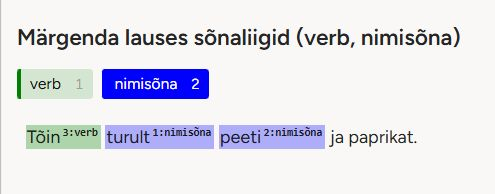

#### Import from Labelstudio

After sentences have been manually annotated in Labelstudio and exported as a JSON file, we can convert them back into EstNLTK's Text objects:

In [9]:
# Read labelstudio exported JSON
with open('ls_json/phrase_tagging_output_json_1.json', 'r', encoding='utf-8') as file:
    input_str = file.read()
# Convert JSON string to estnltk's text objects
tagged_sentences = task.import_data(input_str)
for annotated_sentence in tagged_sentences:
    display(annotated_sentence)
    display(annotated_sentence.annotated_partofspeech)
    print('===='*25)

Text(text='Mees peeti kinni.')

Layer(name='annotated_partofspeech', attributes=('label', 'lead_time', 'created_at', 'updated_at'), spans=SL[Span('Mees', [{'label': 'nimisõna', 'lead_time': None, 'created_at': '2024-11-07T12:45:09.798355Z', 'updated_at': '2024-11-07T12:45:09.798355Z'}]),
Span('peeti', [{'label': 'verb', 'lead_time': None, 'created_at': '2024-11-07T12:45:09.798355Z', 'updated_at': '2024-11-07T12:45:09.798355Z'}])])

Text(text='Tõin turult peeti ja paprikat.')

Layer(name='annotated_partofspeech', attributes=('label', 'lead_time', 'created_at', 'updated_at'), spans=SL[Span('Tõin', [{'label': 'verb', 'lead_time': 25.593, 'created_at': '2024-11-07T12:45:09.798355Z', 'updated_at': '2024-11-07T12:45:44.759763Z'}]),
Span('turult', [{'label': 'nimisõna', 'lead_time': 25.593, 'created_at': '2024-11-07T12:45:09.798355Z', 'updated_at': '2024-11-07T12:45:44.759763Z'}]),
Span('peeti', [{'label': 'nimisõna', 'lead_time': 25.593, 'created_at': '2024-11-07T12:45:09.798355Z', 'updated_at': '2024-11-07T12:45:44.759763Z'}]),
Span('paprikat', [{'label': 'nimisõna', 'lead_time': 25.593, 'created_at': '2024-11-07T12:45:09.798355Z', 'updated_at': '2024-11-07T12:45:44.759763Z'}])])

Note: you can also import JSON-MIN type Labelstudio files, for this, pass parameter `input_type='json-min'` to the importing function:
```python
# Convert JSON-MIN string to estnltk's text objects
tagged_sentences = task.import_data(input_str, input_type='json-min)
```

---

## PhraseClassificationTask

The phrase classification task aims to determine a class of an annotated phrase (or a word). 
Optionally, annotator can also correct boundaries of a predicted phrase.

#### Export to Labelstudio

In the following, we'll show how to prepare data and phrase classification task for labelstudio manual annotation project. 

Let's take a simplified example where the goal is to determine part of speech for the word _'peeti'_ inside a sentence. 
The word will be annotated in sentence, and the annotator has to select the correct part of speech.

In [10]:
from estnltk.converters.label_studio.labelling_configurations import PhraseClassificationConfiguration
from estnltk.converters.label_studio.labelling_tasks import PhraseClassificationTask

In [11]:
# Define example sentences
from estnltk import Text
sentences = [Text('Mees peeti kinni.'), Text('Peeti polnud vaja supile enam lisada.'), Text('Tõin turult peeti ja paprikat.')]

In [12]:
# Automatically mark target word 'peeti' in sentences
from estnltk.taggers.system.rule_taggers.extraction_rules.ruleset import Ruleset
from estnltk.taggers.system.rule_taggers.extraction_rules.static_extraction_rule import StaticExtractionRule
from estnltk.taggers.system.rule_taggers.taggers.substring_tagger import SubstringTagger
rules = Ruleset([
    StaticExtractionRule('peeti', {'label': 'analüüsitav sõna'}),
])
tagger = SubstringTagger(rules, output_attributes=['label'], ignore_case=True)
for sentence in sentences:
    tagger.tag(sentence)
    sentence.terms.display()

Mees peeti kinni.

Peeti polnud vaja supile enam lisada.

Tõin turult peeti ja paprikat.

In [13]:
# Define configuration for phrase classification
conf = PhraseClassificationConfiguration(phrase_labels=['analüüsitav sõna'], class_labels={'verb': 'verb', 'nimisõna': 'nimisõna'},
                                         header="Vali analüüsitava sõna sõnaliik", header_placement='middle')

Configuration parameters: 
* `phrase_labels` determines the content of `<Label>` tags in the labelling interface. It is used to highlight target phrase in text. In our example, the phrase has been fixed and annotator does not have to change it; in a more complex example, annotator might also need to change the phrase boundaries. If the parameter `phrase_labels` is a list, then default coloring scheme is used. To specify background colors, specify parameter `phrase_labels` as a dictionary of label-color pairs.
* `class_label` determines the content of `<Choice>` tags in the labelling interface. Class labels will be displayed along with radio buttons, allowing annotator to make the choice between labels. The key will be displayed to annotator, and the value is alias which will be the actual value in the resulting annotation.
* `header` contains string with annotation instructions to be displayed to annotator. `header_placement` determines the location of the header (`'top'`, `'middle'`, `'bottom'`)

There are more configuration parameters available, see [the source code](https://github.com/estnltk/estnltk/blob/devel_1.7/estnltk/estnltk/converters/label_studio/labelling_configurations/phrase_classification_configuration.py) for details.

In [14]:
# Define task's data importer/exporter
# input_layer, output_layer and label_attribute correspond to tagger's output_layer's parameters
task = PhraseClassificationTask(conf, input_layer=tagger.output_layer, output_layer=tagger.output_layer, label_attribute='label')

In [15]:
# Labelstudio annotation interface
print(task.interface_file)

<View>
  <Labels name="phrase" toName="text" >
    <Label value="analüüsitav sõna" background="green" />
  </Labels>
  <Text name="text" value="$text" />
  <Header value="Vali analüüsitava sõna sõnaliik" />
  <Choices name="phrase_class" toName="text" choice="single-radio" >
    <Choice value="verb" alias="verb" />
    <Choice value="nimisõna" alias="nimisõna" />
  </Choices>
</View>


In [16]:
# Export data into Labelstudio JSON format
print(task.export_data(sentences, indent=2))

[
  {
    "data": {
      "text": "Mees peeti kinni."
    },
    "annotations": [
      {
        "result": [
          {
            "value": {
              "start": 5,
              "end": 10,
              "labels": [
                "anal\u00fc\u00fcsitav s\u00f5na"
              ]
            },
            "from_name": "phrase",
            "to_name": "text",
            "type": "labels"
          }
        ]
      }
    ]
  },
  {
    "data": {
      "text": "Peeti polnud vaja supile enam lisada."
    },
    "annotations": [
      {
        "result": [
          {
            "value": {
              "start": 0,
              "end": 5,
              "labels": [
                "anal\u00fc\u00fcsitav s\u00f5na"
              ]
            },
            "from_name": "phrase",
            "to_name": "text",
            "type": "labels"
          }
        ]
      }
    ]
  },
  {
    "data": {
      "text": "T\u00f5in turult peeti ja paprikat."
    },
    "annotations": [
      {

In [17]:
# Dump data into JSON file (for labelstudio import)
with open('phrase_classification_example_1.json', 'w') as f:
    f.write(task.export_data(sentences, indent=2))

The corresponding annotator interface in Labelstudio:

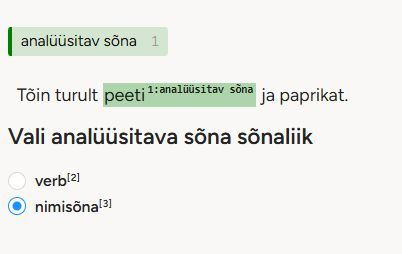

#### Import from Labelstudio

After sentences have been manually annotated in Labelstudio and exported as a JSON file, we can convert them back into EstNLTK's Text objects.

Note that the resulting radio button choices (class labels) will be set as metadata of Text object:

In [18]:
# Read labelstudio exported JSON
with open('ls_json/phrase_classification_output_json_1.json', 'r', encoding='utf-8') as file:
    input_str = file.read()
# Convert JSON string to estnltk's text objects
classified_sentences = task.import_data(input_str)
for annotated_sentence in classified_sentences:
    annotated_sentence.terms.display()
    display(annotated_sentence)

Mees peeti kinni.

Text(text='Mees peeti kinni.')

Peeti polnud vaja supile enam lisada.

Text(text='Peeti polnud vaja supile enam lisada.')

Tõin turult peeti ja paprikat.

Text(text='Tõin turult peeti ja paprikat.')

Note: you can also import JSON-MIN type Labelstudio files, for this, pass parameter `input_type='json-min'` to the importing function:
```python
# Convert JSON-MIN string to estnltk's text objects
classified_sentences = task.import_data(input_str, input_type='json-min)
```

---